# Multi-layer perceptron name generator

## Data preprocessing

First, let's import our dependencies:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

/home/ritsuko/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we import our dataset:

In [2]:
df = pd.read_csv("datasets/names/yob1999.csv", header=None)
# Cool idea: maybe weight this by frequency somehow?
df.columns = ["name", "gender", "count"]
df.head()

,name,gender,count
0,Emily,F,26539
1,Hannah,F,21677
2,Alexis,F,19234
3,Sarah,F,19112
4,Samantha,F,19040


We reprise our data cleaning steps from earlier:

In [3]:
df = df[df["gender"] == "F"]
df["name"] = df["name"].str.lower()
df

,name,gender,count
0,emily,F,26539
1,hannah,F,21677
2,alexis,F,19234
3,sarah,F,19112
4,samantha,F,19040
...,...,...,...
16939,zohal,F,5
16940,zophia,F,5
16941,zuha,F,5
16942,zuhal,F,5


Now we break up the names such that we get the preceding three chars (or ".") in one col and the char itself in another:

In [4]:
test_name = "madison"
def split_name(name):
    pairs = []
    for idx, char in enumerate(name):
        triple = (name[max(0, idx-3):idx].rjust(3, '.'))
        pairs.append((char, triple))

    pairs.append(('.', name[max(0, len(name) - 3):].rjust(3, '.')))
    return(pairs)

split_name(test_name)

[('m', '...'),
 ('a', '..m'),
 ('d', '.ma'),
 ('i', 'mad'),
 ('s', 'adi'),
 ('o', 'dis'),
 ('n', 'iso'),
 ('.', 'son')]

We apply this to all names:

In [5]:
df["pairs"] = df["name"].apply(split_name)
df = df.explode("pairs")
df

,name,gender,count,pairs
0,emily,F,26539,"(e, ...)"
0,emily,F,26539,"(m, ..e)"
0,emily,F,26539,"(i, .em)"
0,emily,F,26539,"(l, emi)"
0,emily,F,26539,"(y, mil)"
...,...,...,...,...
16943,zuzu,F,5,"(z, ...)"
16943,zuzu,F,5,"(u, ..z)"
16943,zuzu,F,5,"(z, .zu)"
16943,zuzu,F,5,"(u, zuz)"


In [6]:
foo = pd.DataFrame(df['pairs'].apply(lambda p: list(p)), index=df.index)
data = pd.DataFrame(foo['pairs'].tolist(), columns=["label", "triple"])
data

,label,triple
0,e,...
1,m,..e
2,i,.em
3,l,emi
4,y,mil
...,...,...
124356,z,...
124357,u,..z
124358,z,.zu
124359,u,zuz


In [7]:
df_old = df
df = data

Finally, we make this into tensors:

In [8]:
def char2idx(c):
    # Assumes valid input
    if c == ".":
        return 0
    else:
        return ord(c) - ord("a") + 1

def idx2char(i):
    if i == 0:
        return ""
    elif i < 28:
        return(chr(i+ord("a")-1))
    else:
        return("ERR")

df["label_int"] = df['label'].apply(char2idx)
labels = F.one_hot(torch.tensor(df["label_int"]), 27)
labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

In [9]:
df['triple']

0         ...
1         ..e
2         .em
3         emi
4         mil
         ... 
124356    ...
124357    ..z
124358    .zu
124359    zuz
124360    uzu
Name: triple, Length: 124361, dtype: object

In [10]:
contexts = torch.tensor(df["triple"].apply(lambda t: list(map(char2idx, t))))
contexts

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [ 0, 26, 21],
        [26, 21, 26],
        [21, 26, 21]])

Finally, we put this into a *bona fide* PyTorch dataset:

In [11]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(contexts, labels)

train_size = int(0.8 * len(contexts))
test_size = len(contexts) - train_size
train_len = int(train_size / len(dataset) * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset= torch.utils.data.random_split(dataset, [train_len,test_len])

## Model setup

### Embed

Now that we have `contexts` and `labels` properly constructed, let's construct the embedding layer.

We embed the *output classes*: 27 chars, in 2 dimensions.

In [12]:
# Name could be better
EMBEDDING_NDIM = 2
C = torch.randn(27, EMBEDDING_NDIM)
C.shape

torch.Size([27, 2])

We can index into a tensor in **multiple dimensions**, which can effectively "index for all" if given another tensor to index in. This way, we can convert *all* our input "context" of 3 chars into embeddings.

In [13]:
# We can index into a tensor **mu
emb = C[contexts]

### Hidden layer

Our "hidden layer" is an arbitrary set of neurons between the input embedding and the target extraction. Let's init:

In [14]:
HIDDEN_NDIM = 100
W1 = torch.randn(6, HIDDEN_NDIM, requires_grad=True)
b1 = torch.randn(HIDDEN_NDIM, requires_grad=True)

We can "index into" this tensor to get our stuff:

In [15]:
# TODO: SRS this
foo = emb.view(-1, 6)
(foo @ W1).shape

torch.Size([124361, 100])

A standard activation would be as follows:

In [16]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([124361, 100])

Finally, as in any other classification problem, we translate from this hidden layer to our output layer:

In [17]:
W2 = torch.randn(HIDDEN_NDIM, 27, requires_grad=True)
B2 = torch.randn(27, requires_grad=True)

Our loss function is the same as many other classification problems: plain old cross-entropy loss again.

## Training loop

I'm just going to write out the entire MLP class at once. This is terrible, but my laziness and depression have forced my hand.

In [18]:
class MLP:
    def __init__(self, embedding_size, hidden_size):
        self.embedding_size = embedding_size
        self.C = torch.randn(27, embedding_size, requires_grad=True)
        # Hidden layer
        self.W1 = torch.randn(3 * embedding_size, hidden_size, requires_grad=True)
        self.B1 = torch.randn(hidden_size, requires_grad=True)
        # Output layer
        self.W2 = torch.randn(hidden_size, 27, requires_grad=True)
        self.B2 = torch.randn(27, requires_grad=True)
    
    def forward(self, x):
        """Takes batch of contexts; returns logits"""
        # Embed batch
        emb = self.C[x]
        # Run hidden layer; apply nonlinearity
        hidden_layer_output = torch.tanh(emb.view(-1,3 * self.embedding_size) @ self.W1 + self.B1)
        # Final layer: crunch down to output logits
        logits = hidden_layer_output @ self.W2 + self.B2
        return(logits)

    def backward(self, x, y_true):
        y_pred = self.forward(x)
        loss = F.cross_entropy(y_pred, y_true)

        # Zero out gradients
        self.C.grad = None
        self.W1.grad = None
        self.B1.grad = None
        self.W2.grad = None
        self.B2.grad = None

        loss.backward()
        print(f"Loss: {loss.item()}")
        return loss
    
    def update_parameters(self, lr):
        # Subtract the gradients
        with torch.no_grad():
            # There HAS to be a better way to do this
            self.C -= lr * self.C.grad
            self.W1 -= lr * self.W1.grad
            self.B1 -= lr * self.B1.grad
            self.W2 -= lr * self.W2.grad
            self.B2 -= lr * self.B2.grad

    def fit_one_cycle(self, x, y_true, lr):
        self.backward(x, y_true)
        self.update_parameters(lr)


Now it merely falls to us to write the driver code:

In [66]:
BATCH_SIZE = 16
EMBEDDING_NDIM = 5
HIDDEN_NDIM = 50
STEPS=10000

# Simple exponential decay
lrs = 10 ** np.linspace(0, -3, STEPS + 1)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
model = MLP(EMBEDDING_NDIM, HIDDEN_NDIM)

global_step = 0
epoch = 0
while global_step < STEPS:
    for step, (data, labels) in enumerate(train_dataloader):
        print(f"Step {global_step}:")
        model.fit_one_cycle(data, labels.float(), lrs[step])

        global_step += 1
        if global_step >= STEPS:
            break
    epoch += 1
    if global_step >= STEPS:
        break


Step 0:
Loss: 14.673314094543457
Step 1:
Loss: 10.640939712524414
Step 2:
Loss: 11.831843376159668
Step 3:
Loss: 9.462662696838379
Step 4:
Loss: 10.251893997192383
Step 5:
Loss: 9.692173957824707
Step 6:
Loss: 9.885221481323242
Step 7:
Loss: 11.083727836608887
Step 8:
Loss: 7.900116920471191
Step 9:
Loss: 8.62112045288086
Step 10:
Loss: 6.193122863769531
Step 11:
Loss: 6.865701675415039
Step 12:
Loss: 10.222563743591309
Step 13:
Loss: 5.394250869750977
Step 14:
Loss: 5.7257080078125
Step 15:
Loss: 5.493692398071289
Step 16:
Loss: 7.1806817054748535
Step 17:
Loss: 6.635244369506836
Step 18:
Loss: 5.454991340637207
Step 19:
Loss: 7.607663631439209
Step 20:
Loss: 8.343095779418945
Step 21:
Loss: 6.424219608306885
Step 22:
Loss: 6.221733570098877
Step 23:
Loss: 8.489809036254883
Step 24:
Loss: 8.827760696411133
Step 25:
Loss: 7.883297920227051
Step 26:
Loss: 6.1079607009887695
Step 27:
Loss: 7.8348069190979
Step 28:
Loss: 6.431997299194336
Step 29:
Loss: 6.463117599487305
Step 30:
Loss: 8.

After some tinkering, we find that small batch sizes (8), linear decay LR from 0.5 to 1e-2, and higher steps decrease rate (severe overfitting begins...)
Finally, we get the loss on the training set (we technically need a validation, but I can't be bothered):

In [67]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_loss = 0
for data, labels in test_dataloader:
    loss = model.backward(data, labels.float())

test_loss

Loss: 2.196570873260498


0

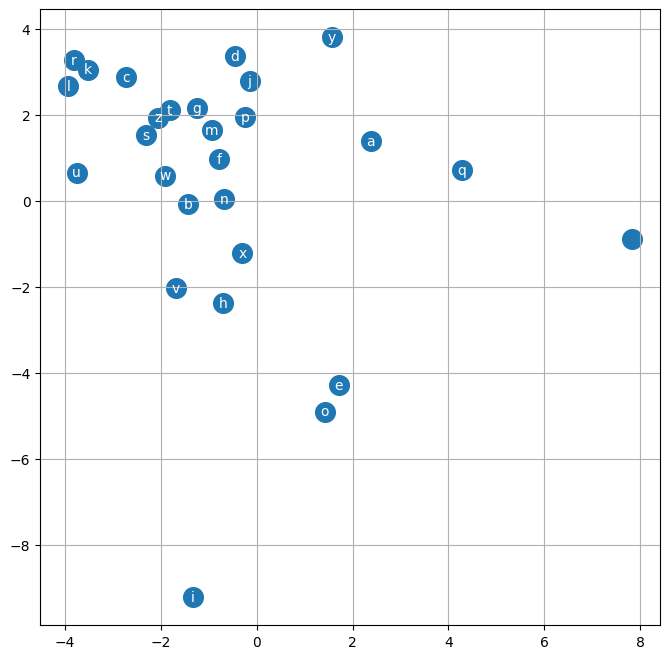

In [222]:
model.plot_embeddings()

## Generation

In [68]:
g = torch.Generator()

for _ in range(20):
    out = []
    context = [0,0,0]
    while True:
        logits = model.forward(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # randomly sample pred from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(idx2char(i) for i in out))

tringelyn
tara
ali
wia
jalon
teliezmina
lanellan
mavkelyanna
maietmarye
cora
lu
zicfania
kristona
kvcena
llon
azauelmala
maki
farti
tura
andanea


## Testing and validation

### Finding the learning rate

This hyperparameter is kind of important (citation needed). To start, we want to implement something like the "learning rate finder", where we exponentially increase lr until we hit a wall and then find it somewhere around there. Let's give it a try! Let's go from $10^{-3}$ to $10^1$ in increments of 2x???

In [60]:
lr_model = MLP(EMBEDDING_NDIM, HIDDEN_NDIM)
lr = 10e-4

# WHY IS THIS LANGUAGE NOT TYPED AARGH
losses = []
i = 0

while lr < 10:
    start, end = i * BATCH_SIZE, (i+1) * BATCH_SIZE
    loss = lr_model.backward(contexts[start:end], labels[start:end].float())
    lr_model.update_parameters(lr)
    losses.append({"loss" : loss.item(), "lr": lr})
    lr *= 1.05
    i+=1

loss_df = pd.DataFrame.from_records(losses)
loss_df["loss_smooth"] = loss_df["loss"].rolling(window=5).mean()

Loss: 7.430624008178711
Loss: 5.907592296600342
Loss: 6.736423969268799
Loss: 6.276147842407227
Loss: 8.191972732543945
Loss: 6.006835460662842
Loss: 7.029684066772461
Loss: 5.80147647857666
Loss: 6.876686096191406
Loss: 6.443017482757568
Loss: 6.2708916664123535
Loss: 5.996418476104736
Loss: 6.9694013595581055
Loss: 7.181060314178467
Loss: 7.285386562347412
Loss: 6.76036262512207
Loss: 4.900427341461182
Loss: 6.592562198638916
Loss: 7.163669586181641
Loss: 6.860597133636475
Loss: 6.350022315979004
Loss: 6.802441120147705
Loss: 5.725580215454102
Loss: 6.045586109161377
Loss: 7.162632465362549
Loss: 6.112359046936035
Loss: 6.745479106903076
Loss: 8.428348541259766
Loss: 7.566260814666748
Loss: 7.213047027587891
Loss: 6.1751508712768555
Loss: 6.329876899719238
Loss: 5.869903087615967
Loss: 6.829679489135742
Loss: 7.537769317626953
Loss: 6.489545822143555
Loss: 6.2317705154418945
Loss: 6.0110626220703125
Loss: 7.265320301055908
Loss: 8.121577262878418
Loss: 6.227502822875977
Loss: 6.25087

Now let's graph this:

In [53]:
import matplotlib.pyplot as plt

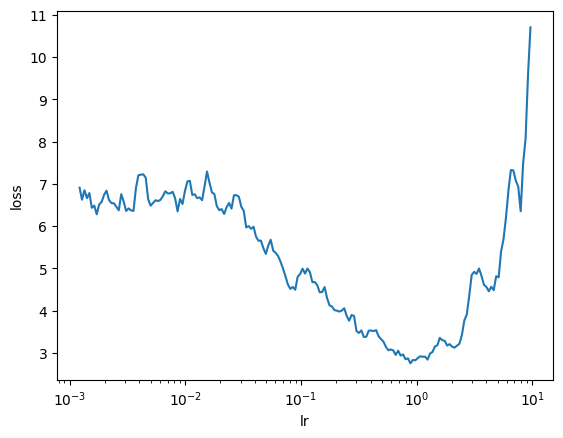

In [61]:
plt.plot(loss_df['lr'], loss_df['loss_smooth'])
plt.xscale('log')
plt.xlabel('lr')
plt.ylabel('loss')
plt.show()


Looks like our initial learning rate wasn't aggressive enough! torch.linspace, -3, 0 10** that. instead of what we did here

## Generation